In [1]:
%matplotlib inline


from keras.models import Model
from keras.callbacks import TensorBoard, EarlyStopping
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Activation, Input, TimeDistributed
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU, ELU, PReLU
from keras.optimizers import RMSprop, Adam, Adadelta, Adagrad
import numpy as np
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import binarize

from assignment.helpers import datapreparation as prep

# Note on specifying the initial state of RNNs
# Seems as though you can reset state (probably stateful=True), and then pass an array of initial states that can be used
# in the RNN - so initialize based on composer :D
# https://keras.io/layers/recurrent/

fs5_dirpath = "./assignment/datasets/training/piano_roll_fs5"
fs1_dirpath = "./assignment/datasets/training/piano_roll_fs1"

datasets = prep.load_all_dataset(fs1_dirpath)
dataset_names = prep.load_all_dataset_names(fs1_dirpath)

datasets = [dataset[:, 1:] for dataset in datasets] # Remove the headers

dataset_id_names = dict(zip(np.arange(len(dataset_names)), dataset_names))
longest_song = max(datasets[i].shape[1] for i in range(len(datasets)))
sequence_length = 5 #40
#b_size = 71 # 4047=3*19*71, 0.2 split ==> 3237 = 3*13*83
length = longest_song//sequence_length + 1
num_keys = len(datasets[0])
parts_per_song = int(longest_song/sequence_length)


def transpose_and_label(datasets, num_keys):
    datasets_transposed = np.array([dataset.T for dataset in datasets])
    datasets_transposed_padded_labels = np.array([np.append(dataset[1:, :], np.array([np.ones(num_keys)]), 0) for dataset in datasets_transposed])
    return datasets_transposed, datasets_transposed_padded_labels

def transpose_and_label_stricter(datasets, num_keys):
    xs, ys = [], []
    datasets_transposed = np.array([dataset.T for dataset in datasets])
    for song in datasets_transposed:
        for i in range(0, len(song)//sequence_length):
            xs.append(song[i*sequence_length:(i+1)*sequence_length])
            if i == len(song)//sequence_length - 1: # Add the EOF marker if last seq of song
                ys.append(np.append(song[i*sequence_length+1:(i+1)*sequence_length], np.array([np.ones(num_keys)]), 0))
            else:
                ys.append(song[i*sequence_length+1:(i+1)*sequence_length+1])
    return xs, ys


# Makes several datasets from this first one with differing intervals between to capture the "gaps" between two sequences
def transpose_and_label_more(datasets, num_keys):
    zs = []
    datasets_transposed = np.array([dataset.T for dataset in datasets])
    for song in datasets_transposed:
        for offset in range(0, sequence_length, 1): # Consider dropping offset, and use stateful to retain this info!
            for i in range(0, len(song)//sequence_length-offset):
                x = song[offset+i*sequence_length:offset+(i+1)*sequence_length]
                if i == len(song)//sequence_length - 1: # Add the EOF marker if last seq of song
                    y = np.append(song[offset+i*sequence_length+1:offset+(i+1)*sequence_length], np.array([np.ones(num_keys)]), 0)
                else:
                    y = song[offset+i*sequence_length+1:offset+(i+1)*sequence_length+1]
                zs.append((x,y))
    zs = np.array(zs)
    np.random.shuffle(zs)
    return zs[:, 0], zs[:, 1]

np.random.shuffle(datasets)
test_sets = datasets[int(0.8*len(datasets)):]
train_sets = datasets[:int(0.8*len(datasets))]
train_xs, train_ys = transpose_and_label_more(train_sets, num_keys)
test_xs, test_ys = transpose_and_label_more(test_sets, num_keys)

inputs = Input(shape=(sequence_length, num_keys))
# Units = units per timestep LSTM block, i.e. output dimensionality (128 here since input and output 128 keys)
lstm1 = LSTM(num_keys,
               activation='relu',
               return_sequences=True,
               stateful=False,
               dropout=0.0, #0.2, #0.25,
               recurrent_dropout=0.0, #0.25,
               kernel_regularizer=None,#l2(0.0001),
               recurrent_regularizer=None, #l2(0.0001),
               bias_regularizer=None,
               activity_regularizer=None, #l2(0.0001),
               )(inputs)
#lstm = LeakyReLU(alpha=.001)(lstm) # Workaround for getting leakyrelu as activation in lstm
normalized1 = BatchNormalization()(lstm1)
dense1 = Dense(num_keys, activation="sigmoid")(normalized1)
lstm2 = LSTM(num_keys,
               activation='relu',
               return_sequences=True,
               stateful=False,
               dropout=0.0, #0.2, #0.25,
               recurrent_dropout=0.0, #0.25,
               kernel_regularizer=None,#l2(0.0001),
               recurrent_regularizer=None, #l2(0.0001),
               bias_regularizer=None,
               activity_regularizer=None,#l2(0.0001),
               )(dense1)
normalized2 = BatchNormalization()(lstm2)
dense2 = Dense(num_keys, activation="sigmoid")(normalized2)
outputs = TimeDistributed(Dense(num_keys, activation="sigmoid"))(normalized2) # Sigmoid keeps the probabilities independent of each other, while softmax does not!

model = Model(inputs=inputs, outputs=outputs)

rmsprop = RMSprop(lr=0.001)
adagrad =  Adagrad(lr=0.001)
adam = Adam(lr=0.001, amsgrad=True) #Ends up in a point where gradients really small, denominator really small and then loss exploding
adadelta = Adadelta(lr=1.0)

#model.save("./models/latest.h5f")
# When LSTM is done can use trainable=False to freeze it while training the other one


Using TensorFlow backend.


In [2]:
keys_not_played = set([i for i in range(num_keys)])
for dataset in datasets:
    for i in range(num_keys):
        if sum(dataset[i,:]) != 0 and i in keys_not_played:
            keys_not_played.remove(i)
print(keys_not_played)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}


In [3]:
# Want to penalize each output node independantly. So we pick a binary loss 
# and model the output of the network as a independent bernoulli distributions per label.

model.compile(loss='binary_crossentropy',
              optimizer=adam, # consider changing this one for others
              metrics=['categorical_accuracy'])
print(model.summary())

tensorboard = TensorBoard(log_dir="./logs/{}".format(time()))
early_stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=3, verbose=0, mode="auto")


model.fit(train_xs, train_ys,
          epochs=500, # Train harder more for more things was too bad train man :(
          batch_size=32,
          shuffle=True, # Should consider a generator and stateful so that trains on full songs and resets stats after each one (also pad them so each makes up full seq im training on)
          validation_data=(test_xs, test_ys),
          callbacks=[tensorboard],
          )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 128)            131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 128)            512       
_________________________________________________________________
dense_1 (Dense)              (None, 5, 128)            16512     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 128)            131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 128)            512       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 128)            16512     
Total para

10345/10345 [==============================] - 11s 1ms/step - loss: 0.0340 - categorical_accuracy: 0.2930 - val_loss: 0.1588 - val_categorical_accuracy: 0.0553- loss: 0.0336 - categorical_ac - ETA: 7s - loss: 0.0337 - catego - ETA: 6s -
Epoch 64/500
10345/10345 [==============================] - 12s 1ms/step - loss: 0.0339 - categorical_accuracy: 0.2958 - val_loss: 0.1617 - val_categorical_accuracy: 0.0513
Epoch 65/500
10345/10345 [==============================] - 15s 1ms/step - loss: 0.0337 - categorical_accuracy: 0.2927 - val_loss: 0.1619 - val_categorical_accuracy: 0.0499
Epoch 66/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0342 - categorical_accuracy: 0.2912 - val_loss: 0.1627 - val_categorical_accuracy: 0.0497ss: 0.0342 - categorical_accu - ETA: 0s - loss: 0.0341 - categorical_accuracy: 0. - ETA: 0s - loss: 0.0342 - categorical_accuracy: 0.29
Epoch 67/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0334 - categorical_accurac

Epoch 142/500
10345/10345 [==============================] - 15s 1ms/step - loss: 0.0250 - categorical_accuracy: 0.3432 - val_loss: 0.2073 - val_categorical_accuracy: 0.0426
Epoch 143/500
10345/10345 [==============================] - 15s 1ms/step - loss: 0.0254 - categorical_accuracy: 0.3419 - val_loss: 0.2076 - val_categorical_accuracy: 0.0431
Epoch 144/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0257 - categorical_accuracy: 0.3408 - val_loss: 0.2131 - val_categorical_accuracy: 0.0436
Epoch 145/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0253 - categorical_accuracy: 0.3418 - val_loss: 0.2099 - val_categorical_accuracy: 0.0461
Epoch 146/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0249 - categorical_accuracy: 0.3412 - val_loss: 0.2137 - val_categorical_accuracy: 0.0443
Epoch 147/500
10345/10345 [==============================] - 15s 1ms/step - loss: 0.0249 - categorical_accuracy: 0.3420 - val_loss

Epoch 229/500
10345/10345 [==============================] - 16s 2ms/step - loss: 0.0214 - categorical_accuracy: 0.3600 - val_loss: 0.2331 - val_categorical_accuracy: 0.0451
Epoch 230/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0213 - categorical_accuracy: 0.3597 - val_loss: 0.2306 - val_categorical_accuracy: 0.0455 categorical_accuracy: 0.
Epoch 231/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0212 - categorical_accuracy: 0.3588 - val_loss: 0.2302 - val_categorical_accuracy: 0.0430s - - ETA: 4s - loss: 0.0211 - categorical_accu - E - ETA: 2s - loss: 0.0211 - catego
Epoch 232/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0211 - categorical_accuracy: 0.3569 - val_loss: 0.2309 - val_categorical_accuracy: 0.0497
Epoch 233/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0213 - categorical_accuracy: 0.3580 - val_loss: 0.2346 - val_categorical_accuracy: 0.0449_
Epoch 234/500
10345

10345/10345 [==============================] - 11s 1ms/step - loss: 0.0193 - categorical_accuracy: 0.3672 - val_loss: 0.2421 - val_categorical_accuracy: 0.0450A: 0s - loss: 0.0193 - categorical_accuracy: 0.
Epoch 314/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0193 - categorical_accuracy: 0.3669 - val_loss: 0.2402 - val_categorical_accuracy: 0.0491
Epoch 315/500
10345/10345 [==============================] - 13s 1ms/step - loss: 0.0193 - categorical_accuracy: 0.3683 - val_loss: 0.2424 - val_categorical_accuracy: 0.0506
Epoch 316/500
10345/10345 [==============================] - 16s 2ms/step - loss: 0.0192 - categorical_accuracy: 0.3665 - val_loss: 0.2425 - val_categorical_accuracy: 0.0506
Epoch 317/500
10345/10345 [==============================] - 12s 1ms/step - loss: 0.0191 - categorical_accuracy: 0.3684 - val_loss: 0.2480 - val_categorical_accuracy: 0.0465
Epoch 318/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0191 - catego

10345/10345 [==============================] - 11s 1ms/step - loss: 0.0178 - categorical_accuracy: 0.3737 - val_loss: 0.2527 - val_categorical_accuracy: 0.0477
Epoch 401/500
10345/10345 [==============================] - 16s 2ms/step - loss: 0.0178 - categorical_accuracy: 0.3737 - val_loss: 0.2515 - val_categorical_accuracy: 0.0484
Epoch 402/500
10345/10345 [==============================] - 15s 1ms/step - loss: 0.0179 - categorical_accuracy: 0.3743 - val_loss: 0.2536 - val_categorical_accuracy: 0.0477 categorical_accuracy - ETA - ETA: 0s - loss: 0.0179 - catego
Epoch 403/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0179 - categorical_accuracy: 0.3707 - val_loss: 0.2545 - val_categorical_accuracy: 0.0482s - loss: 0.0176 - categorical_accu - ETA: 0s - loss: 0.0179 - categorical_accu
Epoch 404/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0178 - categorical_accuracy: 0.3726 - val_loss: 0.2510 - val_categorical_accuracy: 0.0502
Epoc

10345/10345 [==============================] - 11s 1ms/step - loss: 0.0171 - categorical_accuracy: 0.3735 - val_loss: 0.2557 - val_categorical_accuracy: 0.0500
Epoch 487/500
10345/10345 [==============================] - 13s 1ms/step - loss: 0.0171 - categorical_accuracy: 0.3780 - val_loss: 0.2517 - val_categorical_accuracy: 0.0491
Epoch 488/500
10345/10345 [==============================] - 16s 2ms/step - loss: 0.0173 - categorical_accuracy: 0.3741 - val_loss: 0.2543 - val_categorical_accuracy: 0.0497
Epoch 489/500
10345/10345 [==============================] - 13s 1ms/step - loss: 0.0172 - categorical_accuracy: 0.3732 - val_loss: 0.2588 - val_categorical_accuracy: 0.0526loss: 0.0173 - categorical_accuracy: 0. - ETA: 2s - loss: 0.0173 - categorical_accu
Epoch 490/500
10345/10345 [==============================] - 11s 1ms/step - loss: 0.0169 - categorical_accuracy: 0.3763 - val_loss: 0.2572 - val_categorical_accuracy: 0.0480
Epoch 491/500
10345/10345 [==============================] - 

In [6]:
from keras.models import load_model
from keras.models import Model
from keras.callbacks import TensorBoard, EarlyStopping
from keras.layers import LSTM, Dropout, Dense, BatchNormalization, Activation, Input, TimeDistributed
from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU, ELU, PReLU
from keras.optimizers import RMSprop, Adam, Adadelta, Adagrad
model = load_model("./models/notstateful_5offset1_validation.h5f")

In [7]:
%matplotlib inline



import numpy as np
from time import time
from matplotlib import pyplot as plt
from sklearn.preprocessing import binarize

from assignment.helpers import datapreparation as prep

# Note on specifying the initial state of RNNs
# Seems as though you can reset state (probably stateful=True), and then pass an array of initial states that can be used
# in the RNN - so initialize based on composer :D
# https://keras.io/layers/recurrent/

fs5_dirpath = "./assignment/datasets/training/piano_roll_fs5"
fs1_dirpath = "./assignment/datasets/training/piano_roll_fs1"

datasets = prep.load_all_dataset(fs1_dirpath)
dataset_names = prep.load_all_dataset_names(fs1_dirpath)

datasets = [dataset[:, 1:] for dataset in datasets] # Remove the headers

dataset_id_names = dict(zip(np.arange(len(dataset_names)), dataset_names))
longest_song = max(datasets[i].shape[1] for i in range(len(datasets)))
sequence_length = 5 #40
#b_size = 71 # 4047=3*19*71, 0.2 split ==> 3237 = 3*13*83
length = longest_song//sequence_length + 1
num_keys = len(datasets[0])
parts_per_song = int(longest_song/sequence_length)


def transpose_and_label(datasets, num_keys):
    datasets_transposed = np.array([dataset.T for dataset in datasets])
    datasets_transposed_padded_labels = np.array([np.append(dataset[1:, :], np.array([np.ones(num_keys)]), 0) for dataset in datasets_transposed])
    return datasets_transposed, datasets_transposed_padded_labels

def transpose_and_label_stricter(datasets, num_keys):
    xs, ys = [], []
    datasets_transposed = np.array([dataset.T for dataset in datasets])
    for song in datasets_transposed:
        for i in range(0, len(song)//sequence_length):
            xs.append(song[i*sequence_length:(i+1)*sequence_length])
            if i == len(song)//sequence_length - 1: # Add the EOF marker if last seq of song
                ys.append(np.append(song[i*sequence_length+1:(i+1)*sequence_length], np.array([np.ones(num_keys)]), 0))
            else:
                ys.append(song[i*sequence_length+1:(i+1)*sequence_length+1])
    return xs, ys


# Makes several datasets from this first one with differing intervals between to capture the "gaps" between two sequences
def transpose_and_label_more(datasets, num_keys):
    zs = []
    datasets_transposed = np.array([dataset.T for dataset in datasets])
    for song in datasets_transposed:
        for offset in range(0, sequence_length, 1): # Consider dropping offset, and use stateful to retain this info!
            for i in range(0, len(song)//sequence_length-offset):
                x = song[offset+i*sequence_length:offset+(i+1)*sequence_length]
                if i == len(song)//sequence_length - 1: # Add the EOF marker if last seq of song
                    y = np.append(song[offset+i*sequence_length+1:offset+(i+1)*sequence_length], np.array([np.ones(num_keys)]), 0)
                else:
                    y = song[offset+i*sequence_length+1:offset+(i+1)*sequence_length+1]
                zs.append((x,y))
    zs = np.array(zs)
    np.random.shuffle(zs)
    return zs[:, 0], zs[:, 1]

np.random.shuffle(datasets)
test_sets = datasets[int(0.8*len(datasets)):]
train_sets = datasets[:int(0.8*len(datasets))]
train_xs, train_ys = transpose_and_label_more(train_sets, num_keys)
test_xs, test_ys = transpose_and_label_more(test_sets, num_keys)

3475/3475 [==============================] - 2s 642us/step
None
None


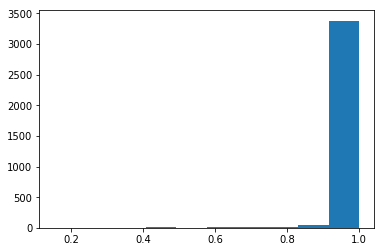

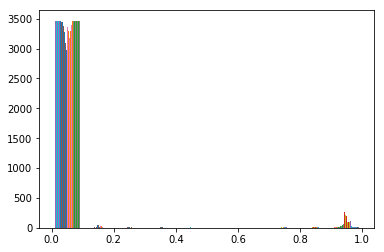

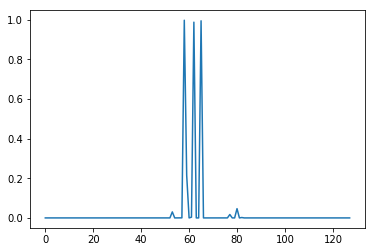

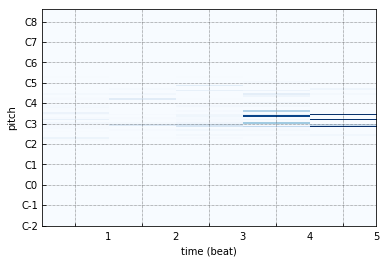

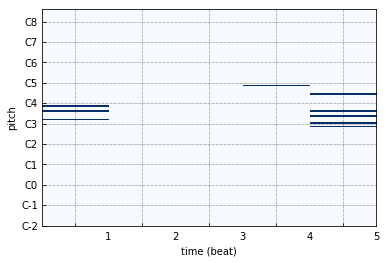

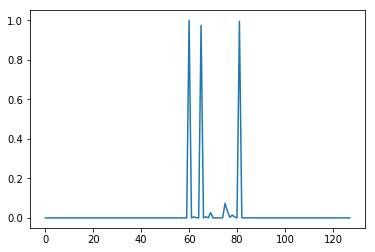

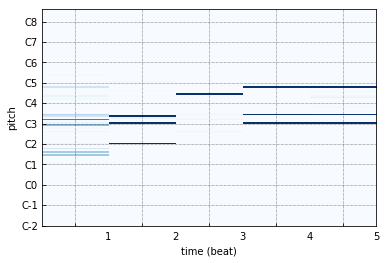

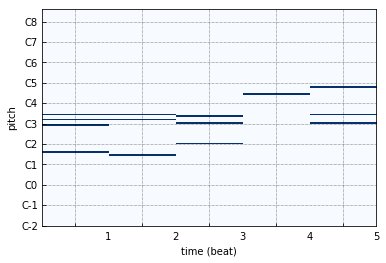

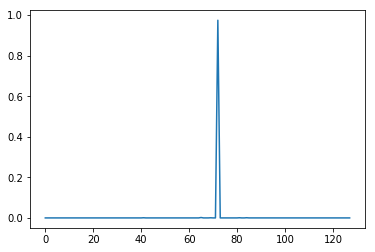

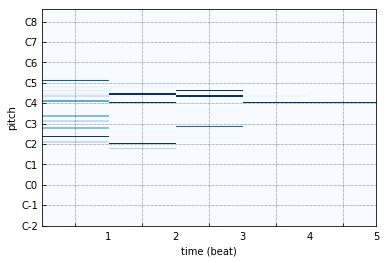

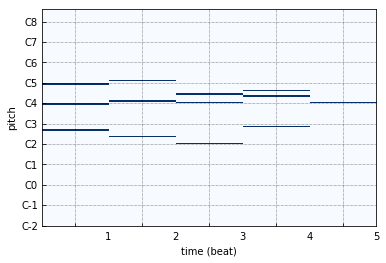

In [8]:
a = model.predict(test_xs, verbose=True)
print(model.layers[1].states[0])
print(model.layers[1].states[0])
maxes = [np.max(c) for c in a]
plt.hist(maxes)
plt.show()
plt.hist(a[:,-1])
plt.show()
b = np.max(a[1][-1])
plt.plot(a[0][-1])
plt.show()
prep.visualize_piano_roll(a[0].T, fs=1)
prep.visualize_piano_roll(test_xs[0].T, fs=1)
plt.plot(a[100][-1])
plt.show()
prep.visualize_piano_roll(a[100].T, fs=1)
prep.visualize_piano_roll(test_xs[100].T, fs=1)
plt.plot(a[200][-1])
plt.show()
prep.visualize_piano_roll(a[200].T, fs=1)
prep.visualize_piano_roll(test_xs[200].T, fs=1)

In [ ]:
def make_song_from_predict(model, initial_data, limit):
    song = []
    keep_producing = True
    prev_data = initial_data
    while keep_producing and len(song) < limit:
        #print("input", prev_data)
        predictions = model.predict(np.array([prev_data]))[0]
        #print("output", predictions[-1])
        #plt.plot(predictions[-1])
        #plt.show()
        labels = np.zeros(predictions.shape)
        labels[predictions>0.5] = 1 # Weak activations, want to scale to 0/1
        last_output = labels[-1]
        #print("output scaled:", last_output)
        keep_producing = np.sum(last_output) != len(last_output)
        song.append(last_output)
        prev_data = np.append(prev_data[1:], [last_output], 0)
    return np.array(song)

initial_step = 1250
song = make_song_from_predict(model, train_xs[initial_step], sequence_length*10)
prep.visualize_piano_roll(song.T, fs=1)
prep.visualize_piano_roll(train_xs[initial_step].T, fs=1)
prep.embed_play_v1(song.T, fs=1)


In [ ]:
prep.visualize_piano_roll(train_xs[initial_step+1].T, fs=1)
prep.embed_play_v1(train_xs[initial_step+1].T, fs=1)

In [22]:
#model.save("./models/notstateful_5offset1_validation.h5f")